# **Lab 6: Differential Equations**
**Christoffer Ejemyr**

# **Abstract**

In [1]:
"""This program is a lab report in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Christoffer Ejemyr (ejemyr@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

In this lab the accuracy and stability of solvers of ordinary differential equations were investigated. It was found that the implicit euler method was stabile and accurate in both scalar and vector situations.

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [2]:
# Load neccessary modules.

import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import newton
from scipy.linalg import expm

from typing import Callable, Union

# **Introduction**

In this lab we will investigate the accuracy of solvers of ordinary differential methods (ODE). We will focus on the equation

$$\frac{du}{dt} = Au(t), $$

both in the case of scalar as well as vecor functions $u$.

# **Methods**

## Scalar implicit Euler method

We choose to implement the numeric solver with th implicit euler method using the algorithm given in the lecturenote and the newton solver of the scipy package.

In [3]:
def scalar_implicit_euler(func: Callable[[float, float], float], u0: float, t_max: float = 100):
    dt = 1e-1
    
    steps = int(t_max / dt) + 1
    t, dt = np.linspace(0, t_max, num=steps, retstep=True)
    u = np.r_[u0, np.zeros(steps - 1)]
    
    for i in range(1, len(t)):
        u[i] = newton(lambda x: x - u[i - 1] - dt * func(x, t[i]), u[i - 1])
        
    return u, t

## Test scalar solver
To test the solver we compare the itterated solution with a true solution. We test for the differential equation

$$\frac{du}{dt} = \lambda u(t),$$

where $\lambda < 0$. This ODE has the exact solution $u(t) = u_0 e^{\lambda t}$ for some initial value $u_0$. We plot both the exact solution and the estimated solution as well as the absolute relative error of the solution. The relative error is defined by

$$\frac{|u_{est} - u_{true}|}{|u_0|}.$$

If the estimated solution stabilises over time the solver is stable and if the error approches zero the solution is said to be accurate.

In [4]:
def get_f(A: Union[int, float, np.ndarray]) -> Callable[[float, float], float]:
    if isinstance(A, int) or isinstance(A, float):
        def f(u: float, t: float) -> float:
            return A * u
        return f
    elif isinstance(A, np.ndarray):
        if A.ndim == 2:
            def f(u: np.ndarray, t: np.ndarray) -> np.ndarray:
                return A.dot(u)
            return f
        else:
            raise TypeError(get_f.__name__ + " can't take non-matrix array")
    else:
        raise TypeError(get_f.__name__ + " can't take input of type " + str(type(A)))

In [5]:
def test_scalar():
    u0_list = [-10, -1, 0, 1, 10]
    T = 10
    
    const = -1
    f = get_f(const)
    
    true_sols, est_sols = [], []
    
    fig, ax = plt.subplots(2, 1)
    
    for u0 in u0_list:
        est, t = scalar_implicit_euler(f, u0, T)
        est_sols.append(est)
        true_sols.append(u0 * np.exp(const * t))
    
    ax[0].set_title(r"Solutions with estimate")
    for true, est in zip(true_sols, est_sols):
        ax[0].plot(t, true, 'k')
        ax[0].plot(t, est, 'r--')


    ax[1].set_title(r"Relative error $\left(\frac{|est - true|}{u_0}\right)$")
    for true, est, u0 in zip(true_sols, est_sols, u0_list):
        error = abs(est - true)
        rel_error = error
        if u0 != 0:
            rel_error /= abs(u0)
        ax[1].plot(t, rel_error, label=r"$u_0=$" + str(u0))
    ax[1].legend()
    plt.show()

## Implicit Euler for system of equations

As with the scalar solution we use the implicit euler method.

In [6]:
def system_implicit_euler(func: Callable[[np.ndarray, np.ndarray], np.ndarray], u0: np.ndarray, t_max: float):
    dt = 1e-1
    
    steps = int(round(t_max / dt)) + 1
    t, dt = np.linspace(0, t_max, num=steps, retstep=True)
    u = np.zeros((u0.size, steps))
    u[:, 0] = u0
    
    for i in range(0, len(t) - 1):
        u[:, i+1] = newton(lambda x: x - u[:, i] - dt * func(x, t[i]), u[:, i])
        
    return u, t



## Test system solver

Similar to the scalar case we study the equation

$$\frac{du}{dt} = Au(t).$$

To easily be able to have an explicit solution we constrain the matrix $A$ to being diagonalizable ($A = XDX^{-1}$). We also impose the condition that $diag(D) < 0$. Therefor we find the folowing solution:

$$\frac{du}{dt} = Au(t) \Rightarrow \frac{du}{dt} = XDX^{-1}u(t) \Rightarrow u(t) = Xe^{Dt}X^{-1}u_0,$$

for some initial vector $u_0$.

In the same manner as before we plot the true solution, the estimation and the error. This time we plot the norm of the estimate/solution and the norm of the error. This is done for solutions of random initial vectors $u_0$.

In [7]:
def get_true_sol(X: np.ndarray, D: np.ndarray, u0: np.ndarray, t_list: np.ndarray):
    return np.array([X.dot(np.diag(np.exp(np.diag(D) * t))).dot(np.linalg.inv(X)).dot(u0) for t in t_list]).T

def test_system():
    D = np.diag(np.array([-1,-2,-3]))
    X = np.array([[1/np.sqrt(2), 0, -1/np.sqrt(2)],[1/np.sqrt(2), 0, 1/np.sqrt(2)],[0, 1, 0]])
    A = X.dot(D).dot(np.linalg.inv(X))

    u0_list = 10 * (np.random.rand(5, D.shape[0]) - 0.5)
    T = 10
    
    f = lambda u, t: A.dot(u)
    
    fig, ax = plt.subplots(2, 1)
    
    for u0 in u0_list:
        est, t = system_implicit_euler(f, u0, T)
        true = get_true_sol(X, D, u0, t)
        
        ax[0].set_title("Solution")
        ax[0].plot(t, np.linalg.norm(est, axis=0))
        ax[1].set_title("Error")
        ax[1].plot(t, np.linalg.norm(est - true, axis=0))
    
    plt.show()

## Random stuff

In [12]:
def stochastic_trajectory(mu, sigma, t_max:float, dt: float = 1e-1):
    steps = int(round(t_max / dt)) + 1
    t, dt = np.linspace(0, t_max, num=steps, retstep=True)
    x = np.zeros(steps)
    for i in range(1, steps):
        x[i] = x[i - 1] + mu * dt + sigma * np.random.normal() * np.sqrt(dt)
        
    return x

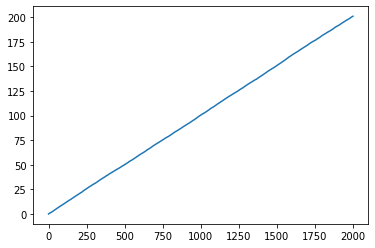

In [13]:
mu = 1
sigma = 1
t_max = 200
num_of_traj = 100
trajectories = np.array([stochastic_trajectory(mu, sigma, t_max) for _ in range(num_of_traj)])
plt.figure()
plt.plot(np.mean(trajectories, axis=0))

# Result

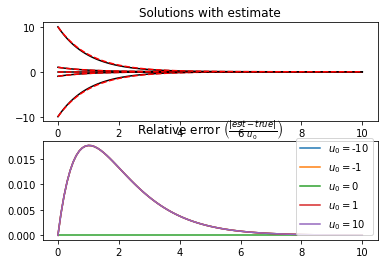

In [10]:
test_scalar()

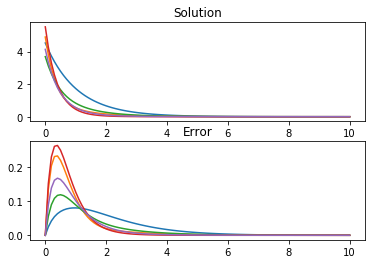

In [11]:
test_system()

# Discussion

Looking at the resulting graphs above it is clear that in both the scalar and the systems case the solutions are both accurate (small errors approching zero) and stable (approching constant value).